# Bootstrapping and machine learning

We recently improved the interface of `resample` to make it easy to bootstrap training data sets for machine learning (ML) classifiers. So, this example demonstrates how one can bootstrap the ROC curve of a classifier from the training data set, without a separate validation set. In other words, this allows one to use the full data set for training and one obtains a very smooth ROC curve.

Sounds too good to be true? Maybe it is! The bootstrap only work well with classifiers that build a smooth representation of the decision boundary, like a neural network. It does not work well with classifiers that use sharp decision boundaries which depend on the locations of individual points, like a boosted decision tree, random forest, or a kNN.

Below we compute a bootstrapped ROC curve for the MLP and RandomForest classifiers from Scikit-Learn, a standard ROC curve from a train-test split, and finally from a separately generated high-statistics data set. The latter serves as an estimate of the "true" ROC curve. In case of the Random Forest, the bootstrapped ROC curve is too optimistic, while in case of the MLP it is ok.

In [1]:
from resample.bootstrap import resample
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
# original data
X, y = datasets.make_moons(1000, noise=0.3, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# original classifiers
mlp = MLPClassifier(max_iter=1000) # iterations increased to avoid warning
mlp.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

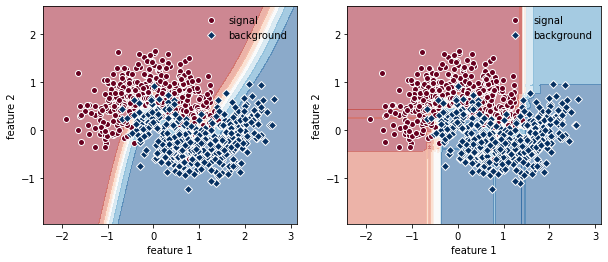

In [3]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

cm = plt.cm.RdBu

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for axi, clf in zip(ax, [mlp, rf]):
    plt.sca(axi)

    # plot the training points
    plt.plot(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], "o",
             color=cm(0.0), mec="w", label="signal")
    plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "D",
             color=cm(1.0), mec="w", label="background")

    # plot models
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5, zorder=0)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.legend(frameon=False);

In [4]:
# generate ROC curve with validation set (standard method)
fpr1 = {}
tpr1 = {}
for clf in (mlp, rf):
    fpr1[clf], tpr1[clf], _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

In [5]:
# generate ROC curve from separately-generated high-statistics data set
fpr2 = {}
tpr2 = {}
X_hs, y_hs = datasets.make_moons(100000, noise=0.3, random_state=1)
for clf in (mlp, rf):
    fpr2[clf], tpr2[clf], _ = roc_curve(y_hs, clf.predict_proba(X_hs)[:, 1])

In [6]:
# generate ROC curve from training data with 20 bootstrap samples
fpr3 = {}
tpr3 = {}
w_s = {}
w_b = {}
for clf in (mlp, rf):
    s = 0
    b = 0
    xrange = (0, 1)
    bins = 50
    for Xi, yi in resample(X_train, y_train, size=20):
        clf.fit(Xi, yi)
        pi = clf.predict_proba(X)[:, 1]
        s += np.histogram(pi[y == 1], range=xrange, bins=bins)[0]
        b += np.histogram(pi[y == 0], range=xrange, bins=bins)[0]

    w_s[clf] = s
    w_b[clf] = b
    tpr3[clf] = 1 - np.cumsum(s) / np.sum(s)
    fpr3[clf] = 1 - np.cumsum(b) / np.sum(b)

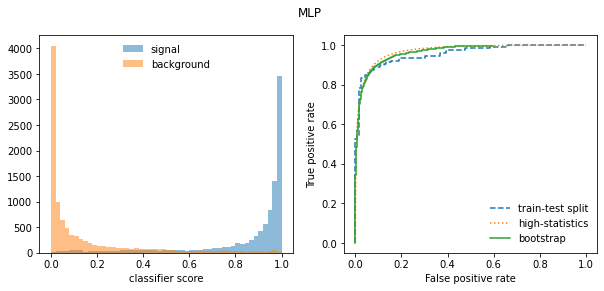

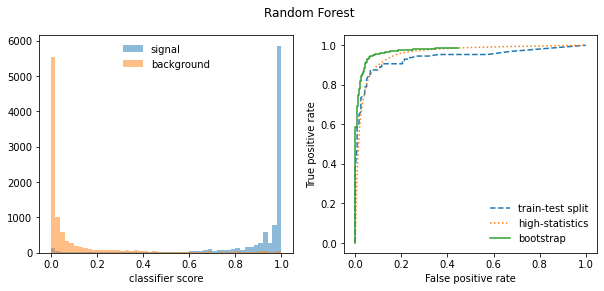

In [7]:
for clf in (mlp, rf):
    # plot score distributions for signal and background
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle({mlp: "MLP", rf: "Random Forest"}[clf])
    
    xe = np.linspace(*xrange, bins + 1)
    plt.sca(ax[0])
    plt.stairs(w_s[clf], xe, fill=True, alpha=0.5, label="signal")
    plt.stairs(w_b[clf], xe, fill=True, alpha=0.5, label="background")
    plt.legend(frameon=False, loc="upper center")
    plt.xlabel("classifier score");
    
    # plot ROC curves
    plt.sca(ax[1])
    plt.plot(fpr1[clf], tpr1[clf], ls="--", label="train-test split")
    plt.plot(fpr2[clf], tpr2[clf], ls=":", label="high-statistics")
    plt.plot(fpr3[clf], tpr3[clf], drawstyle="steps-post", label="bootstrap")
    plt.legend(frameon=False)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")